# Ofri koren supervised Learning Project

This notebook has two main parts:

1. Regression – predicting a country's GDP using Covid-related and economic data.
2. Classification – predicting customer churn.

I try to go through the usual ML steps: load data, clean it, do a bit of exploration, train a couple of models and compare them, and in the end save the best models with joblib.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, confusion_matrix, classification_report
)
import joblib

# Nice display options
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (7, 4)


I upload the two CSV files that were given in the assignment:

- `Covid19_With_GDP_Values.csv`
- `customer_churn_dataset.csv`

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Covid19_With_GDP_Values.csv to Covid19_With_GDP_Values (1).csv
Saving customer_churn_dataset.csv to customer_churn_dataset (1).csv


In [ ]:
cov = pd.read_csv("Covid19_With_GDP_Values.csv")
churn = pd.read_csv("customer_churn_dataset.csv")

print("Covid dataset shape:", cov.shape)
print("Churn dataset shape:", churn.shape)

cov.head()

Covid dataset shape: (340, 10)
Churn dataset shape: (64374, 12)


,Unnamed: 0,Country/Region,Date,Province/State,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
0,0,Afghanistan,2021-01-01,0,52513.0,2201.0,41727.0,1.426650e+10,11.934,NaN
1,1,Afghanistan,2022-01-01,0,158107.0,7356.0,0.0,1.450216e+10,14.100,NaN
2,2,Albania,2021-01-01,0,58316.0,1181.0,33634.0,1.793057e+10,12.473,123.448662
3,3,Albania,2022-01-01,0,210224.0,3217.0,0.0,1.891638e+10,11.588,131.750835
4,4,Algeria,2021-01-01,0,99897.0,2762.0,67395.0,1.862654e+11,13.607,166.218895


## Part A: Regression Covid and GDP

In this part I want to build a regression model that predicts the GDP of a country using the Covid-related variables and some economic indicators.


In [ ]:
cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      340 non-null    int64  
 1   Country/Region  340 non-null    object 
 2   Date            340 non-null    object 
 3   Province/State  340 non-null    object 
 4   Confirmed       340 non-null    float64
 5   Deaths          340 non-null    float64
 6   Recovered       340 non-null    float64
 7   GDP             340 non-null    float64
 8   Unemployment    340 non-null    float64
 9   CPI             338 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 26.7+ KB


In [ ]:
cov.describe(include="all")

,Unnamed: 0,Country/Region,Date,Province/State,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
count,340.000000,340,340,340,3.400000e+02,340.000000,3.400000e+02,3.400000e+02,340.000000,338.000000
unique,NaN,170,2,9,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Afghanistan,2021-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,170,324,NaN,NaN,NaN,NaN,NaN,NaN
mean,169.500000,NaN,NaN,NaN,7.634973e+05,15951.067647,1.208214e+05,3.944683e+11,7.888956,517.033368
std,98.293777,NaN,NaN,NaN,2.646129e+06,53453.623073,6.823575e+05,1.514594e+12,6.165982,2882.653141
min,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,5.906598e+07,0.130000,99.399284
25%,84.750000,NaN,NaN,NaN,1.272250e+04,139.500000,0.000000e+00,1.170607e+10,3.674750,123.018580
50%,169.500000,NaN,NaN,NaN,1.060575e+05,1450.500000,0.000000e+00,3.969701e+10,5.805000,138.575074
75%,254.250000,NaN,NaN,NaN,4.712660e+05,7970.500000,2.104050e+04,2.465499e+11,10.474500,185.339822


In [ ]:
cov.isna().sum()

,0
Unnamed: 0,0
Country/Region,0
Date,0
Province/State,0
Confirmed,0
Deaths,0
Recovered,0
GDP,0
Unemployment,0
CPI,2


### Cleaning the Covid data

From the initial look, there are a few obvious things:

- `Unnamed: 0` is just an index column from the file, so I can drop it.
- `Province/State` in this dataset is basically 0 for all rows, so it doesn't add any information.
- `Date` is not really needed here because I will later combine the data by country (so I won't model time directly).
- For the target `GDP`: rows with missing GDP are not useful for training, so I remove them.
- For numeric columns with a few missing values (for example `CPI`) I just fill with the median to keep things simple.
- I also remove duplicate rows if there are any.


In [ ]:
cov_clean = cov.copy()

cols_to_drop = []
for col in ["Unnamed: 0", "Province/State", "Date"]:
    if col in cov_clean.columns:
        cols_to_drop.append(col)

cov_clean = cov_clean.drop(columns=cols_to_drop)

if "GDP" in cov_clean.columns:
    cov_clean = cov_clean.dropna(subset=["GDP"])

if "CPI" in cov_clean.columns:
    if cov_clean["CPI"].isna().sum() > 0:
        cpi_median = cov_clean["CPI"].median()
        cov_clean["CPI"] = cov_clean["CPI"].fillna(cpi_median)

print("Missing values after basic cleaning:")
print(cov_clean.isna().sum())

before_dups = cov_clean.shape[0]
cov_clean = cov_clean.drop_duplicates()
after_dups = cov_clean.shape[0]

print("Rows before removing duplicates:", before_dups)
print("Rows after removing duplicates:", after_dups)
print("Shape after cleaning:", cov_clean.shape)

cov_clean.head()


Missing values after basic cleaning:
Country/Region    0
Confirmed         0
Deaths            0
Recovered         0
GDP               0
Unemployment      0
CPI               0
dtype: int64
Rows before removing duplicates: 340
Rows after removing duplicates: 340
Shape after cleaning: (340, 7)


,Country/Region,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
0,Afghanistan,52513.0,2201.0,41727.0,1.426650e+10,11.934,138.575074
1,Afghanistan,158107.0,7356.0,0.0,1.450216e+10,14.100,138.575074
2,Albania,58316.0,1181.0,33634.0,1.793057e+10,12.473,123.448662
3,Albania,210224.0,3217.0,0.0,1.891638e+10,11.588,131.750835
4,Algeria,99897.0,2762.0,67395.0,1.862654e+11,13.607,166.218895


#### Small exploration

Before building a model, I want see how GDP is distributed and how it relates to some of the numric variables


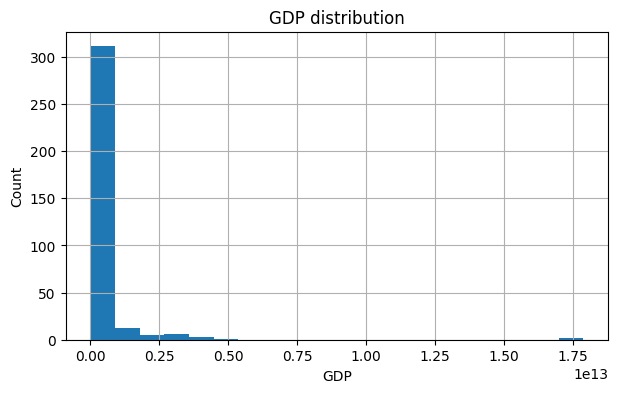

In [ ]:
cov_clean["GDP"].hist(bins=20)
plt.title("GDP distribution")
plt.xlabel("GDP")
plt.ylabel("Count")
plt.show()

In [ ]:
numeric_cols = [c for c in cov_clean.columns if cov_clean[c].dtype != "O"]
corr = cov_clean[numeric_cols].corr()["GDP"].sort_values(ascending=False)
corr

,GDP
GDP,1.000000
Confirmed,0.240673
Deaths,0.220050
Recovered,0.136753
CPI,-0.020091
Unemployment,-0.095667


### Aggregating by country

The dataset has multiple rows per country (different dates).  
For the regression model I prefer to work with one row per country.

So I group by `Country/Region 'and take the mean of all numeric columns.  
This gives:

- one row per country
- average values of the Covid and economic variables
- GDP as the target colunm


In [ ]:
cov_country = cov_clean.groupby("Country/Region").mean(numeric_only=True).reset_index()

print("Number of countries:", cov_country.shape[0])
cov_country.head()

Number of countries: 170


,Country/Region,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
0,Afghanistan,105310.0,4778.5,20863.5,1.438433e+10,13.0170,138.575074
1,Albania,134270.0,2199.0,16817.0,1.842347e+10,12.0305,127.599748
2,Algeria,159357.5,4523.0,33697.5,2.059128e+11,13.0220,173.919413
3,Andorra,15928.5,112.0,3731.5,3.352643e+09,12.4370,181.619932
4,Angola,49983.0,1088.5,5573.0,8.545244e+10,15.2460,645.998608


### Features and target (regression)

- Target variable :`GDP`
- Features: all the other columns.
- `Country/Region` is categorical, so I turn it into dummy variables with `get_dummies`.

Then I split the data into a training set and a test set (80%/20%)


In [ ]:
# Target
y_reg = cov_country["GDP"]

# Features
X_reg = cov_country.drop(columns=["GDP"])

X_reg = pd.get_dummies(X_reg, columns=["Country/Region"], drop_first=True)

print("X_reg shape:", X_reg.shape)
print("y_reg shape:", y_reg.shape)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
print("Train rows:", X_reg_train.shape[0])
print("Test rows:", X_reg_test.shape[0])

X_reg shape: (170, 174)
y_reg shape: (170,)
Train rows: 136
Test rows: 34


### Training regression models

I train two different regression models:

1. **Linear Regression** – a simple linear model that is easy to interpret.
2. **Random Forest Regressor** – an ensemble of decision trees that can handle non-linear relationships.

I use pretty standard parameters and focus more on comparing their performance than tuning them.


In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_reg_train, y_reg_train)

# Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=150,
    random_state=42
)
rf_reg.fit(X_reg_train, y_reg_train)

RandomForestRegressor(n_estimators=150, random_state=42)

### evaluation (regression)

For each model I calculate:

- MSE (mean squared error)
- RMSE (root mean squared error)
- MAE (mean absolute error)
- R² score

This lets me compare how well they predict GDP on the test set.


In [ ]:
def regression_report(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}")
    print("-" * len(name))
    print("MSE :", round(mse, 2))
    print("RMSE:", round(rmse, 2))
    print("MAE :", round(mae, 2))
    print("R^2 :", round(r2, 4))
    print()

y_pred_lin = lin_reg.predict(X_reg_test)
y_pred_rf = rf_reg.predict(X_reg_test)

regression_report("Linear Regression", y_reg_test, y_pred_lin)
regression_report("Random Forest", y_reg_test, y_pred_rf)


Linear Regression
-----------------
MSE : 2.0953112258519098e+23
RMSE: 457745696413.62
MAE : 323300678112.53
R^2 : 0.684

Random Forest
-------------
MSE : 1.6128220956311728e+23
RMSE: 401599563698.86
MAE : 198209394895.58
R^2 : 0.7568



#### Random Forest has higher R² and lower RMSE, so I choose it as the final model

### Final regression model and saving

Based on the comperison above I choose the better model (usually the one with higher R² and lower errors).  
I retrain that model on all the data (train + test combined) and save it using `joblib`.  
I also save the feature names so it will be easier to use the model later.


In [ ]:
best_reg_model = rf_reg
best_reg_model.fit(X_reg, y_reg)

regression_package = {
    "model": best_reg_model,
    "feature_columns": X_reg.columns.tolist()
}

joblib.dump(regression_package, "best_gdp_regression_model.joblib")
print("Saved regression model to best_gdp_regression_model.joblib")

Saved regression model to best_gdp_regression_model.joblib


In [ ]:
loaded_reg = joblib.load("best_gdp_regression_model.joblib")
sample_pred = loaded_reg["model"].predict(X_reg.iloc[[0]])
print("Example predicted GDP for first country:", sample_pred[0])

Example predicted GDP for first country: 16959150133.08943


## Part B: Classification – Customer Churn

In this part I build a classifier that predicts whether a customer is likely to churn (leave) or not.

The target column is Churn (0 for no, 1 for yes).


In [ ]:
churn.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [ ]:
churn.isna().sum()

,0
CustomerID,0
Age,0
Gender,0
Tenure,0
Usage Frequency,0
Support Calls,0
Payment Delay,0
Subscription Type,0
Contract Length,0
Total Spend,0


### Basic exploration of the churn data

I check the class balance and the main numeric columns, just to understand what I’m dealing with.

In [ ]:
churn["Churn"].value_counts(normalize=True)

,proportion
Churn,
0,0.526315
1,0.473685


In [ ]:
numeric_cols_churn = [c for c in churn.columns if churn[c].dtype != "O" and c != "CustomerID"]
churn[numeric_cols_churn].describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


### Cleaning the churn data

Decision here:

- `CustomerID` is only an identifier, so I drop it.
- If there are rows with missing values, I drop them to keep it simple (the dataset is not huge).
- Later I will convert the categorical variables into dummy variables.


In [ ]:
churn_clean = churn.copy()

if "CustomerID" in churn_clean.columns:
    churn_clean = churn_clean.drop(columns=["CustomerID"])

before_na = churn_clean.shape[0]
churn_clean = churn_clean.dropna()
after_na = churn_clean.shape[0]

print("Rows before dropping NA:", before_na)
print("Rows after dropping NA:", after_na)
print("Shape after cleaning:", churn_clean.shape)

churn_clean.head()

Rows before dropping NA: 64374
Rows after dropping NA: 64374
Shape after cleaning: (64374, 11)


,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,53,Female,58,24,9,2,Standard,Annual,533,18,0


### Preparing features and target (classification)

- Target (`y_clf`): `Churn`
- Features (`X_clf`): all the other columns.

Categorical columns that need encoding:
- `Gender`
- `Subscription Type`
- `Contract Length`

I use `pd.get_dummies` to convert them to numeric dummy variables, then split into train/test.


In [ ]:
y_clf = churn_clean["Churn"]
X_clf = churn_clean.drop(columns=["Churn"])

X_clf = pd.get_dummies(
    X_clf,
    columns=["Gender", "Subscription Type", "Contract Length"],
    drop_first=True
)

print("X_clf shape:", X_clf.shape)
print("y_clf shape:", y_clf.shape)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

print("Train rows:", X_clf_train.shape[0])
print("Test rows:", X_clf_test.shape[0])

X_clf shape: (64374, 12)
y_clf shape: (64374,)
Train rows: 51499
Test rows: 12875


### Training the churn classifier

For the churn prediction I use a Logistic Regression model.  
I only increase `max_iter` to make sure the optimization converges.

In [ ]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_clf_train, y_clf_train)

LogisticRegression(max_iter=5000)

In [ ]:
log_reg.score(X_clf_train, y_clf_train)

0.8251616536243422

### Evaluation (classification)

I evaluate the model on the test set using:

- Accuracy
- Confusion matrix
- Classification report (precision, recall, F1-score)

This shows how well the model separates churn vs. non-churn customers.


In [ ]:
y_clf_pred = log_reg.predict(X_clf_test)

acc = accuracy_score(y_clf_test, y_clf_pred)
cm = confusion_matrix(y_clf_test, y_clf_pred)
report = classification_report(y_clf_test, y_clf_pred)

print("Accuracy:", round(acc, 4))
print("\nConfusion matrix:")
print(cm)
print("\nClassification report:")
print(report)

Accuracy: 0.8317

Confusion matrix:
[[5656 1137]
 [1030 5052]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6793
           1       0.82      0.83      0.82      6082

    accuracy                           0.83     12875
   macro avg       0.83      0.83      0.83     12875
weighted avg       0.83      0.83      0.83     12875



### Final churn model and saving

Finally I train the Logistic Regression model on the full dataset (train + test combined) and save it with `joblib`.  
Again I also save the list of feature columns.

In [ ]:
log_reg_full = LogisticRegression(max_iter=5000)
log_reg_full.fit(X_clf, y_clf)

classification_package = {
    "model": log_reg_full,
    "feature_columns": X_clf.columns.tolist()
}

joblib.dump(classification_package, "customer_churn_logistic_model.joblib")
print("Saved classification model to customer_churn_logistic_model.joblib")

Saved classification model to customer_churn_logistic_model.joblib


In [ ]:
loaded_clf = joblib.load("customer_churn_logistic_model.joblib")
sample_churn_pred = loaded_clf["model"].predict(X_clf.iloc[[0]])
print("Example predicted churn for first customer (0=no, 1=yes):", sample_churn_pred[0])

Example predicted churn for first customer (0=no, 1=yes): 1


### I didnt have so much fun making this project, ive missed alot of classes lately due to a new job but it doesnt change the fact that im a bit behind on the meterial and this project really showed me that